In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
smagnan_1_million_reddit_comments_from_40_subreddits_path = kagglehub.dataset_download('smagnan/1-million-reddit-comments-from-40-subreddits')

print('Data source import complete.')


100%|██████████| 71.2M/71.2M [00:04<00:00, 17.2MB/s]

Extracting files...


Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
# Install libraries
!pip install transformers datasets torch tqdm seaborn matplotlib plotly networkx wordcloud

import pandas as pd
import numpy as np
import re
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import pipeline


In [6]:
data = pd.read_csv('/root/.cache/kagglehub/datasets/smagnan/1-million-reddit-comments-from-40-subreddits/versions/1/kaggle_RC_2019-05.csv')
data.head()


,subreddit,body,controversiality,score
0,gameofthrones,Your submission has been automatically removed...,0,1
1,aww,"Dont squeeze her with you massive hand, you me...",0,19
2,gaming,It's pretty well known and it was a paid produ...,0,3
3,news,You know we have laws against that currently c...,0,10
4,politics,"Yes, there is a difference between gentle supp...",0,1


In [8]:
# Drop null or deleted comments
data = data.dropna(subset=['body'])
data = data[data['body'].str.lower().ne('[deleted]')]
data = data[data['body'].str.lower().ne('[removed]')]

# Text cleaning
def clean_text(text):
    text = re.sub(r"http\S+", "", text)         # remove URLs
    text = re.sub(r"@\S+", "", text)            # remove mentions
    text = re.sub(r"[^A-Za-z0-9\s]", "", text)  # remove punctuation
    text = re.sub(r"\s+", " ", text)            # normalize spaces
    return text.strip().lower()

data['clean_body'] = data['body'].apply(clean_text)

print(f"Dataset size after cleaning: {len(data)} rows")

Dataset size after cleaning: 1000000 rows


In [9]:
from transformers import pipeline

# Use pretrained toxicity model from Hugging Face
toxic_detector = pipeline("text-classification", model="unitary/toxic-bert", truncation=True, device=0)

# Sample a manageable subset for GPU memory
sample_data = data.sample(2000, random_state=42).reset_index(drop=True)

# Predict toxicity
tqdm.pandas()
sample_data['toxicity_output'] = sample_data['clean_body'].progress_apply(lambda x: toxic_detector(x)[0])
sample_data['toxicity_label'] = sample_data['toxicity_output'].apply(lambda x: x['label'])
sample_data['toxicity_score'] = sample_data['toxicity_output'].apply(lambda x: x['score'])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/811 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0
100%|██████████| 2000/2000 [00:18<00:00, 106.40it/s]


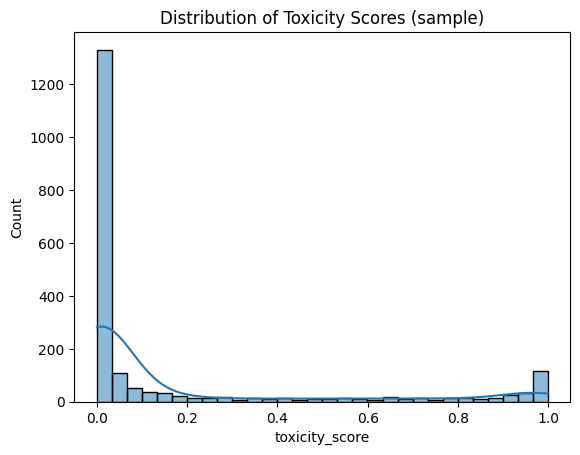

In [10]:
sns.histplot(sample_data['toxicity_score'], bins=30, kde=True)
plt.title("Distribution of Toxicity Scores (sample)")
plt.show()


/tmp/ipython-input-223502971.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=toxic_by_subreddit.values, y=toxic_by_subreddit.index, palette="Reds_r")


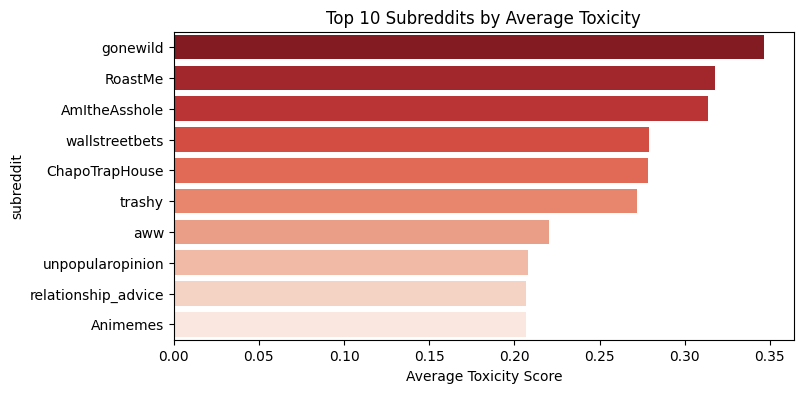

In [11]:
toxic_by_subreddit = sample_data.groupby('subreddit')['toxicity_score'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(8,4))
sns.barplot(x=toxic_by_subreddit.values, y=toxic_by_subreddit.index, palette="Reds_r")
plt.title("Top 10 Subreddits by Average Toxicity")
plt.xlabel("Average Toxicity Score")
plt.show()


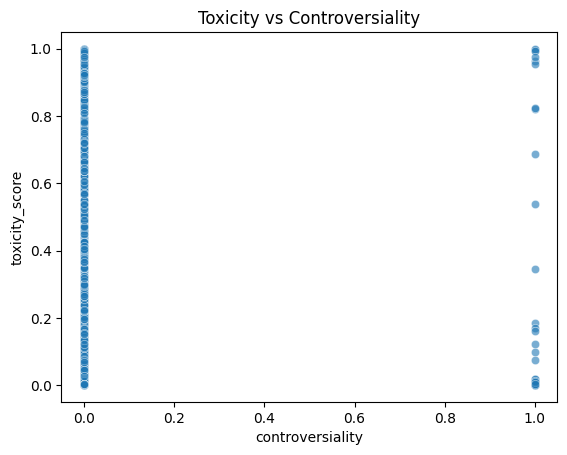

In [12]:
sns.scatterplot(data=sample_data, x='controversiality', y='toxicity_score', alpha=0.6)
plt.title("Toxicity vs Controversiality")
plt.show()


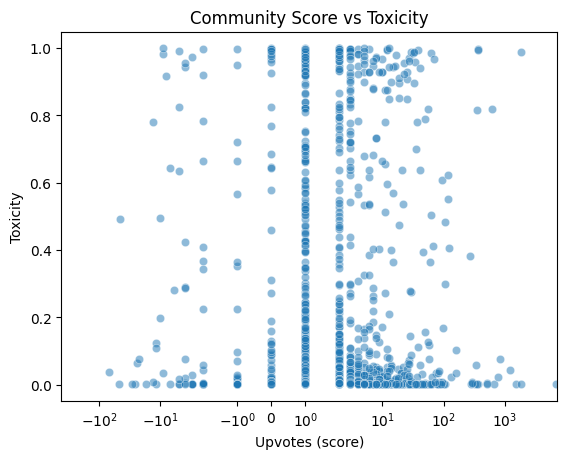

In [13]:
sns.scatterplot(data=sample_data, x='score', y='toxicity_score', alpha=0.5)
plt.xscale('symlog')
plt.title("Community Score vs Toxicity")
plt.xlabel("Upvotes (score)")
plt.ylabel("Toxicity")
plt.show()


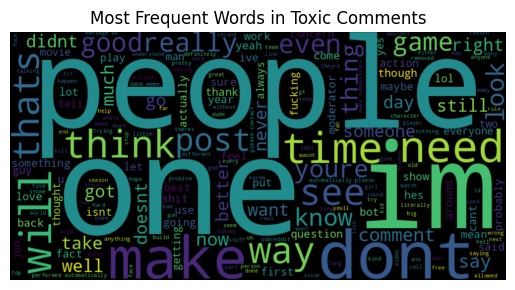

In [14]:
from wordcloud import WordCloud

toxic_comments = ' '.join(sample_data[sample_data['toxicity_label'] == 'toxic']['clean_body'])
wordcloud = WordCloud(width=1000, height=500, background_color='black').generate(toxic_comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words in Toxic Comments")
plt.show()


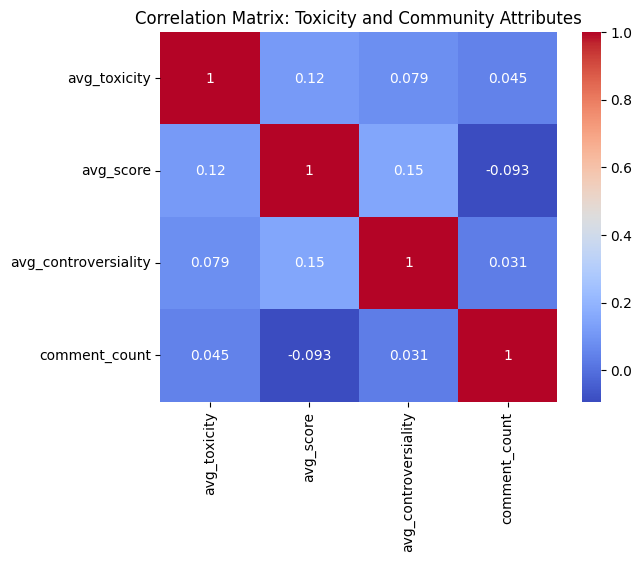

In [15]:
# Compute subreddit-level metrics
subreddit_stats = (
    sample_data.groupby('subreddit')
    .agg({
        'toxicity_score': ['mean', 'std'],
        'score': 'mean',
        'controversiality': 'mean',
        'body': 'count'
    })
)
subreddit_stats.columns = ['avg_toxicity', 'std_toxicity', 'avg_score', 'avg_controversiality', 'comment_count']
subreddit_stats = subreddit_stats.reset_index()

# Correlations
corr = subreddit_stats[['avg_toxicity', 'avg_score', 'avg_controversiality', 'comment_count']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix: Toxicity and Community Attributes")
plt.show()


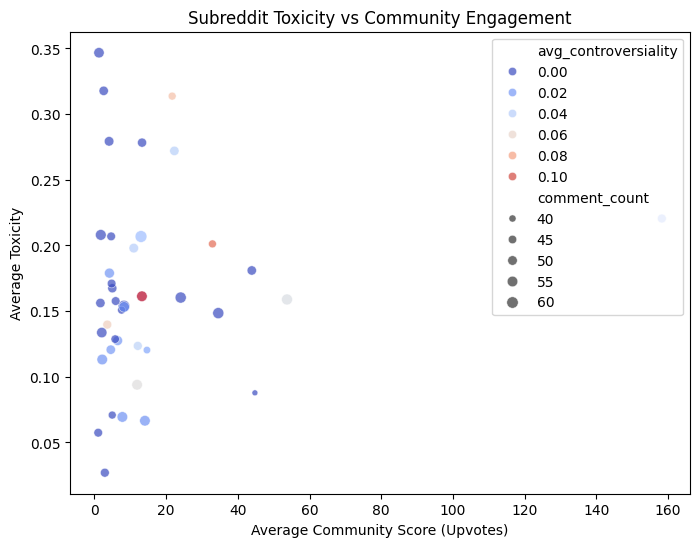

In [16]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=subreddit_stats,
    x='avg_score',
    y='avg_toxicity',
    size='comment_count',
    hue='avg_controversiality',
    alpha=0.7,
    palette='coolwarm'
)
plt.title("Subreddit Toxicity vs Community Engagement")
plt.xlabel("Average Community Score (Upvotes)")
plt.ylabel("Average Toxicity")
plt.show()


In [17]:
summary = subreddit_stats[['subreddit', 'avg_toxicity', 'avg_score', 'avg_controversiality', 'comment_count']].sort_values('avg_toxicity', ascending=False).head(10)
print(summary)


              subreddit  avg_toxicity   avg_score  avg_controversiality  \
20             gonewild      0.346734    1.259259              0.000000   
8               RoastMe      0.317719    2.571429              0.000000   
0         AmItheAsshole      0.313695   21.674419              0.069767   
38       wallstreetbets      0.279284    4.080000              0.000000   
3        ChapoTrapHouse      0.278281   13.270833              0.000000   
35               trashy      0.271994   22.285714              0.040816   
14                  aww      0.220513  158.255319              0.021277   
36     unpopularopinion      0.208024    1.767857              0.000000   
31  relationship_advice      0.206899    4.652174              0.000000   
1              Animemes      0.206796   12.983871              0.032258   

    comment_count  
20             54  
8              49  
0              43  
38             50  
3              48  
35             49  
14             47  
36            

In [20]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# Normalize the numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(subreddit_stats[['avg_toxicity', 'avg_score', 'avg_controversiality']])

# Compute pairwise cosine similarity between subreddits
similarity_matrix = cosine_similarity(X_scaled)
similarity_df = pd.DataFrame(similarity_matrix,
                             index=subreddit_stats['subreddit'],
                             columns=subreddit_stats['subreddit'])


In [21]:
import networkx as nx

# Create graph
G = nx.Graph()

# Add nodes
for sub in subreddit_stats['subreddit']:
    G.add_node(sub)

# Add edges based on similarity threshold
threshold = 0.7
for i, sub_i in enumerate(subreddit_stats['subreddit']):
    for j, sub_j in enumerate(subreddit_stats['subreddit']):
        if i < j and similarity_df.iloc[i, j] > threshold:
            G.add_edge(sub_i, sub_j, weight=similarity_df.iloc[i, j])


In [22]:
# Basic metrics
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
density = nx.density(G)
avg_degree = sum(dict(G.degree()).values()) / num_nodes

print(f"Nodes: {num_nodes}, Edges: {num_edges}, Density: {density:.3f}, Avg Degree: {avg_degree:.2f}")

# Centrality measures
centrality = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G)
closeness = nx.closeness_centrality(G)


Nodes: 40, Edges: 134, Density: 0.172, Avg Degree: 6.70


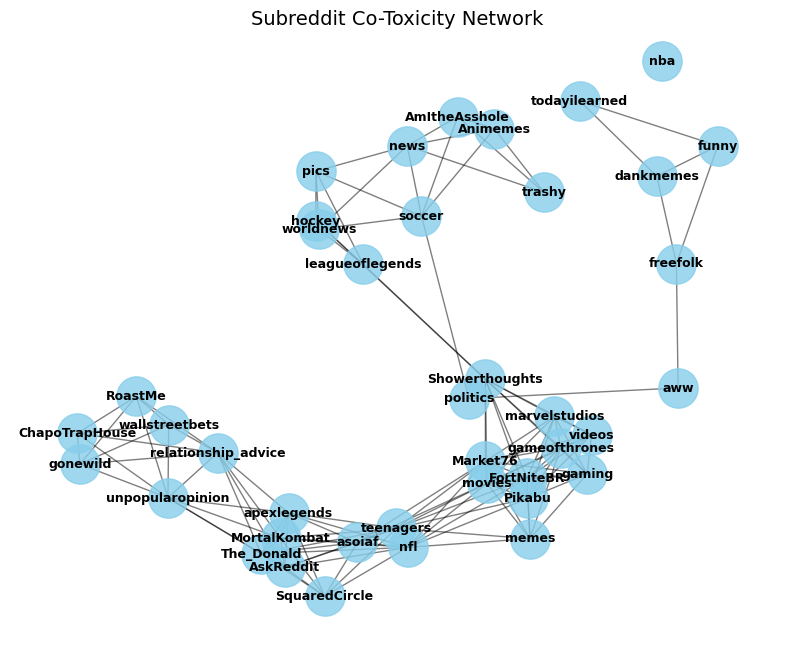

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=800, node_color='skyblue', alpha=0.8)
nx.draw_networkx_edges(G, pos, width=1, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')

plt.title("Subreddit Co-Toxicity Network", fontsize=14)
plt.axis("off")
plt.show()


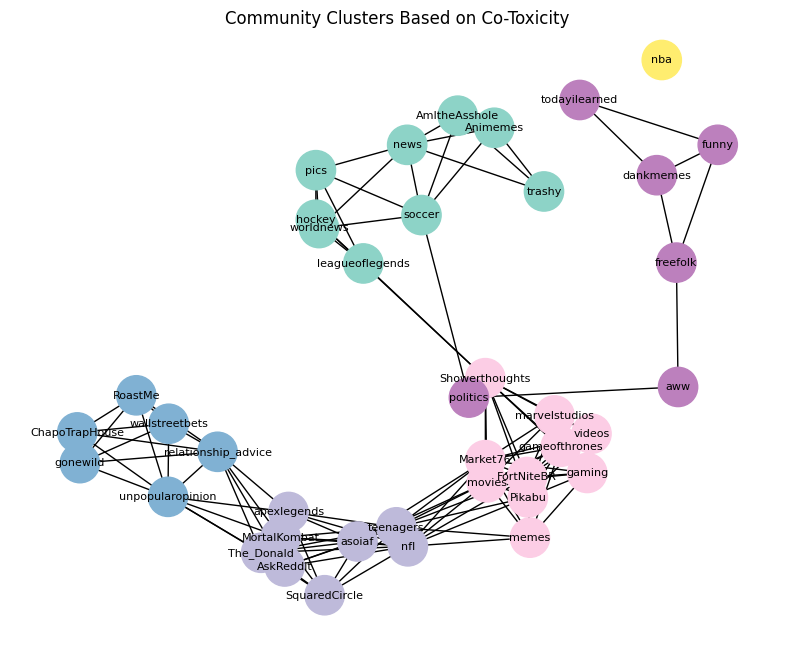

In [24]:
import community.community_louvain as community_louvain

# Perform Louvain clustering
partition = community_louvain.best_partition(G, weight='weight')

# Add cluster labels to your data
subreddit_stats['cluster'] = subreddit_stats['subreddit'].map(partition)

# Visualize clusters
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5, seed=42)
colors = [partition[node] for node in G.nodes()]
nx.draw_networkx(G, pos, node_color=colors, with_labels=True, cmap=plt.cm.Set3, node_size=800, font_size=8)
plt.title("Community Clusters Based on Co-Toxicity")
plt.axis("off")
plt.show()
